# **Bước 1: Import thư viện**

In [75]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import math
import datetime as dt
import matplotlib.pyplot as plt #vẽ biểu đồ
import seaborn as sb


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import load_model #tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# **Bước 2: Đọc dữ liệu**

In [76]:
# đọc dữ liệu từ file csv
df = pd.read_csv('Du lieu Lich su VNM 2013_2023.csv')

In [77]:
df

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất,KL,% Thay đổi
0,21/07/2023,"73,500.0","72,500.0","75,000.0","72,400.0",3.12M,1.10%
1,20/07/2023,"72,700.0","72,600.0","72,900.0","72,300.0",2.45M,0.14%
2,19/07/2023,"72,600.0","72,500.0","73,000.0","72,400.0",2.95M,0.28%
3,18/07/2023,"72,400.0","72,500.0","72,600.0","72,200.0",2.93M,0.14%
4,17/07/2023,"72,300.0","73,000.0","73,600.0","72,200.0",3.92M,-1.36%
...,...,...,...,...,...,...,...
2500,16/07/2013,"96,528.0","95,139.0","97,222.0","95,139.0",729.69K,1.46%
2501,15/07/2013,"95,139.0","95,139.0","95,833.0","94,444.0",176.98K,0.00%
2502,12/07/2013,"95,139.0","94,444.0","95,139.0","93,750.0",220.82K,0.74%
2503,11/07/2013,"94,444.0","94,444.0","95,139.0","93,750.0",161.84K,0.00%


In [78]:
# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

In [79]:
# Hiển thị lại DataFrame sau khi xóa

df

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
0,21/07/2023,"73,500.0","72,500.0","75,000.0","72,400.0"
1,20/07/2023,"72,700.0","72,600.0","72,900.0","72,300.0"
2,19/07/2023,"72,600.0","72,500.0","73,000.0","72,400.0"
3,18/07/2023,"72,400.0","72,500.0","72,600.0","72,200.0"
4,17/07/2023,"72,300.0","73,000.0","73,600.0","72,200.0"
...,...,...,...,...,...
2500,16/07/2013,"96,528.0","95,139.0","97,222.0","95,139.0"
2501,15/07/2013,"95,139.0","95,139.0","95,833.0","94,444.0"
2502,12/07/2013,"95,139.0","94,444.0","95,139.0","93,750.0"
2503,11/07/2013,"94,444.0","94,444.0","95,139.0","93,750.0"


# **Bước 3: Mô tả dữ liệu**

In [80]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [81]:
#kích thước dữ liệu
df.shape

(2505, 5)

In [82]:
#dữ liệu 5 dòng đầu
df.head()

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
0,2023-07-21,"73,500.0","72,500.0","75,000.0","72,400.0"
1,2023-07-20,"72,700.0","72,600.0","72,900.0","72,300.0"
2,2023-07-19,"72,600.0","72,500.0","73,000.0","72,400.0"
3,2023-07-18,"72,400.0","72,500.0","72,600.0","72,200.0"
4,2023-07-17,"72,300.0","73,000.0","73,600.0","72,200.0"


In [83]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ngày       2505 non-null   datetime64[ns]
 1   Đóng cửa   2505 non-null   object        
 2   Mở cửa     2505 non-null   object        
 3   Cao nhất   2505 non-null   object        
 4   Thấp nhất  2505 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 98.0+ KB


In [84]:
# Xem khoảng thời gian của bộ dữ liệu
print("Ngày đầu tiên trong bộ dữ liệu: ", df.iloc[-1][0])
print("Ngày cuối cùng trong bộ dữ liệu: ",df.iloc[0][0])
print("Khoảng thời gian: ", df.iloc[0][0]-df.iloc[-1][0])

Ngày đầu tiên trong bộ dữ liệu:  2013-07-10 00:00:00
Ngày cuối cùng trong bộ dữ liệu:  2023-07-21 00:00:00
Khoảng thời gian:  3663 days 00:00:00


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\835474774.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ngày đầu tiên trong bộ dữ liệu: ", df.iloc[-1][0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\835474774.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ngày cuối cùng trong bộ dữ liệu: ",df.iloc[0][0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\835474774.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

In [85]:
#mô tả bộ dữ liệu
df.describe()

,Ngày
count,2505
mean,2018-07-17 16:17:14.730539008
min,2013-07-10 00:00:00
25%,2016-01-13 00:00:00
50%,2018-07-19 00:00:00
75%,2021-01-14 00:00:00
max,2023-07-21 00:00:00


# **Bước 4: Tiền xử lý dữ liệu**

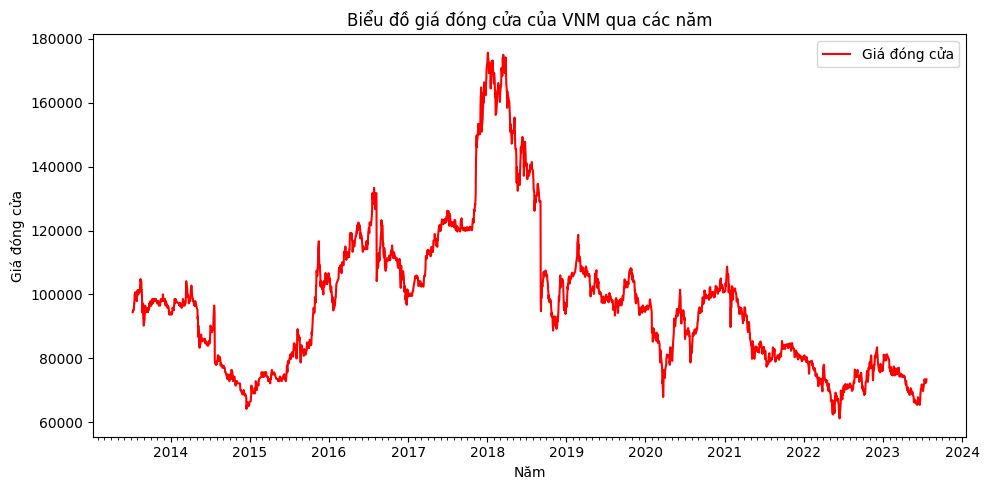

In [86]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Đóng cửa'] = df['Đóng cửa'].str.replace(',', '').astype(float)
df['Mở cửa'] = df['Mở cửa'].str.replace(',', '').astype(float)
df['Cao nhất'] = df['Cao nhất'].str.replace(',', '').astype(float)
df['Thấp nhất'] = df['Thấp nhất'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Đóng cửa'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\4171228357.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\4171228357.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df[col])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\4171228357.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `hist

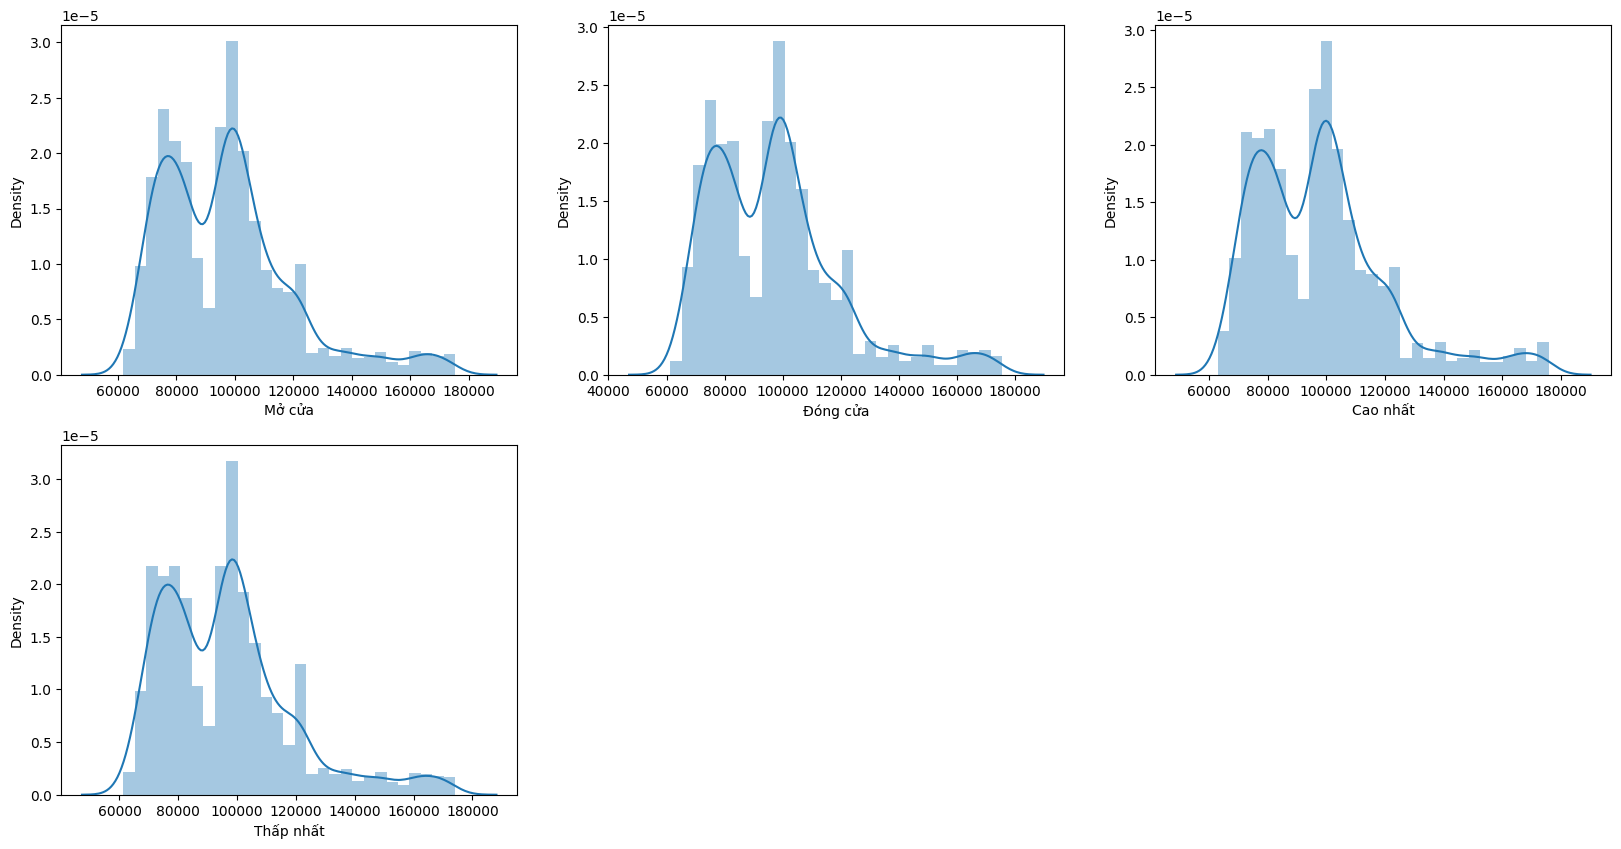

In [87]:
features = ['Mở cửa', 'Đóng cửa', 'Cao nhất', 'Thấp nhất']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

In [88]:
df1 = pd.DataFrame(df,columns=['Ngày','Đóng cửa'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1.head()

,Đóng cửa
Ngày,
2013-07-10,94444.0
2013-07-11,94444.0
2013-07-12,95139.0
2013-07-15,95139.0
2013-07-16,96528.0


Chia tập dữ liệu

In [89]:
df1.head()

,Đóng cửa
Ngày,
2013-07-10,94444.0
2013-07-11,94444.0
2013-07-12,95139.0
2013-07-15,95139.0
2013-07-16,96528.0


In [90]:

data = df1['Đóng cửa']

# using the train test split function
train_data, test_data = train_test_split(data ,
								random_state=104,
								test_size=0.2,
								shuffle=True)

# printing out train and test sets

print('data_train : ')
print(train_data.head())
print(train_data.shape)
print('')
print('data_test : ')
print(test_data.head())
print(test_data.shape)
print('')


data_train : 
Ngày
2017-07-21    121308.0
2022-04-18     73132.2
2019-11-07    103923.0
2014-06-02     86111.0
2016-12-15    100793.0
Name: Đóng cửa, dtype: float64
(2004,)

data_test : 
Ngày
2022-10-14     72700.1
2018-12-21     95091.0
2013-08-15    104861.0
2014-08-28     77083.0
2015-12-28    105833.0
Name: Đóng cửa, dtype: float64
(501,)



Chuẩn hóa dữ liệu

In [91]:

sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(df1.values)

In [92]:
## Tạo tập x_train và y_train

In [93]:
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) # giá đóng cửa 50 ngày cuối cùng trong tệp dữ liệu
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [94]:

x_train #x_train là một chuỗi các giá trị đóng cửa liên tiếp trong quá khứ.

[array([0.29027738, 0.29027738, 0.29635691, 0.29635691, 0.30850724,
        0.31457803, 0.31457803, 0.33887869, 0.34494948, 0.34494948,
        0.32672836, 0.33279915, 0.33887869, 0.32065757, 0.32672836,
        0.34494948, 0.34494948, 0.35102902, 0.33887869, 0.35102902,
        0.34494948, 0.34494948, 0.34494948, 0.34494948, 0.35709981,
        0.36925013, 0.38140046, 0.37532967, 0.37532967, 0.35102902,
        0.35102902, 0.33279915, 0.29027738, 0.31457803, 0.30850724,
        0.27205626, 0.26598547, 0.25383514, 0.27205626, 0.29027738,
        0.30850724, 0.30850724, 0.29027738, 0.3024277 , 0.3024277 ,
        0.29635691, 0.3024277 , 0.29635691, 0.29635691, 0.29027738]),
 array([0.29027738, 0.29635691, 0.29635691, 0.30850724, 0.31457803,
        0.31457803, 0.33887869, 0.34494948, 0.34494948, 0.32672836,
        0.33279915, 0.33887869, 0.32065757, 0.32672836, 0.34494948,
        0.34494948, 0.35102902, 0.33887869, 0.35102902, 0.34494948,
        0.34494948, 0.34494948, 0.34494948, 0.

In [95]:
y_train #y_train chứa giá trị đóng cửa  tiếp theo mà mô hình dự đoán.

[0.2963569134842401,
 0.30242770379791795,
 0.2963569134842401,
 0.30242770379791795,
 0.3145780319617488,
 0.30850724164807086,
 0.3145780319617488,
 0.32065756981190174,
 0.30850724164807086,
 0.3145780319617488,
 0.30850724164807086,
 0.3145780319617488,
 0.3145780319617488,
 0.3145780319617488,
 0.3267283601255797,
 0.3145780319617488,
 0.3145780319617488,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.32065756981190174,
 0.32065756981190174,
 0.3145780319617488,
 0.3145780319617488,
 0.3145780319617488,
 0.32065756981190174,
 0.32065756981190174,
 0.3145780319617488,
 0.30850724164807086,
 0.30850724164807086,
 0.30850724164807086,
 0.30850724164807086,
 0.30850724164807086,
 0.32065756981190174,
 0.3267283601255797,
 0.3267283601255797,
 0.32065756981190174,
 0.32065756981190174,
 0.32065756

In [96]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

In [97]:
#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

## 5.1.MÔ HÌNH GRU

### Xây dựng mô hình GRU

In [98]:
time_step = 50
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [99]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 50, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16065 (62.75 KB)
Trainable params: 16065 (62.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
# Chia tập dữ liệu
data = df1.values
train_data, test_data = train_test_split(data, random_state=104, test_size=0.2, shuffle=True)

# Lấy dữ liệu kiểm thử và kiểm tra
sc_test = sc.transform(test_data.reshape(-1, 1))

In [101]:
# # Chuẩn bị dữ liệu kiểm thử tương tự như dữ liệu huấn luyện
# x_test, y_test = [], []

# for i in range(50, len(test_data)):
#     x_test.append(sc_test[i - 50:i, 0])
#     y_test.append(sc_test[i, 0])

# # Chuyển đổi dữ liệu kiểm thử thành mảng
# x_test = np.array(x_test)
# y_test = np.array(y_test)

# # Reshape dữ liệu kiểm thử
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# y_test = np.reshape(y_test, (y_test.shape[0], 1))
# Tạo dữ liệu test cho mô hình
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])
    y_test.append(sc_train[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))


HUẤN LUYỆN DỮ LIỆU

In [102]:
history3 = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=32,verbose=1)

Epoch 1/20


62/62 [==============================] - 7s 45ms/step - loss: 0.0149 - val_loss: 4.8548e-04
Epoch 2/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0029 - val_loss: 3.0962e-04
Epoch 3/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0024 - val_loss: 2.6089e-04
Epoch 4/20
62/62 [==============================] - 2s 33ms/step - loss: 0.0020 - val_loss: 3.1712e-04
Epoch 5/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0022 - val_loss: 9.3567e-04
Epoch 6/20
62/62 [==============================] - 2s 33ms/step - loss: 0.0019 - val_loss: 7.3100e-04
Epoch 7/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0019 - val_loss: 2.2790e-04
Epoch 8/20
62/62 [==============================] - 2s 33ms/step - loss: 0.0016 - val_loss: 2.6405e-04
Epoch 9/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0017 - val_loss: 4.2770e-04
Epoch 10/20
62/62 [==============================] - 2s 32ms/step - loss: 0.0017 - v

KIỂM TRA VÀ SỬ DỤNG MÔ HÌNH

15/15 [==============================] - 3s 19ms/step
Mức độ phù hợp: 0.9863170553794884
Độ sai số tuyệt đối trung bình của tập test: 764.147839869734
Phần trăm sai số tuyệt đối trung bình của tập test: 0.009248679912209937


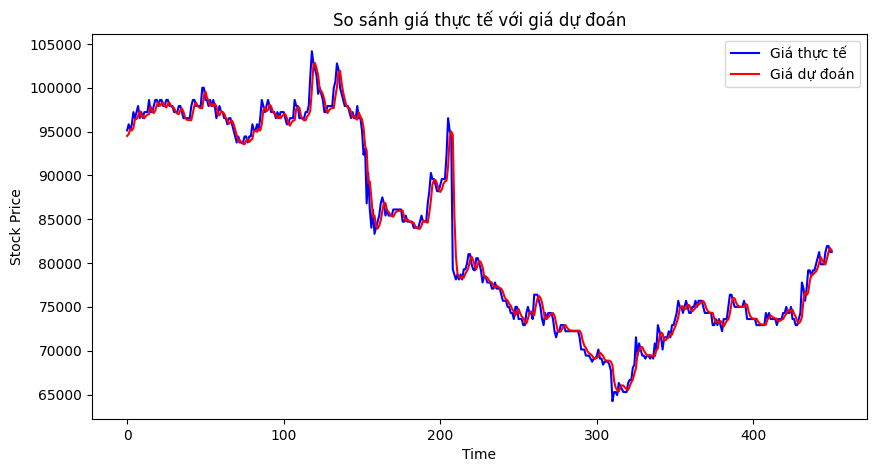

In [103]:
# Dự đoán giá đóng cửa trên tập test
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)

# Đánh giá mô hình
r2 = r2_score(y_test, predicted_stock_price)
mae = mean_absolute_error(y_test, predicted_stock_price)
mape = mean_absolute_percentage_error(y_test, predicted_stock_price)

# In các chỉ số đánh giá
print(f'Mức độ phù hợp: {r2}')
print(f'Độ sai số tuyệt đối trung bình của tập test: {mae}')
print(f'Phần trăm sai số tuyệt đối trung bình của tập test: {mape}')

# Hiển thị biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Giá thực tế', color='blue')
plt.plot(predicted_stock_price, label='Giá dự đoán', color='red')
plt.title('So sánh giá thực tế với giá dự đoán')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='best')
plt.show()

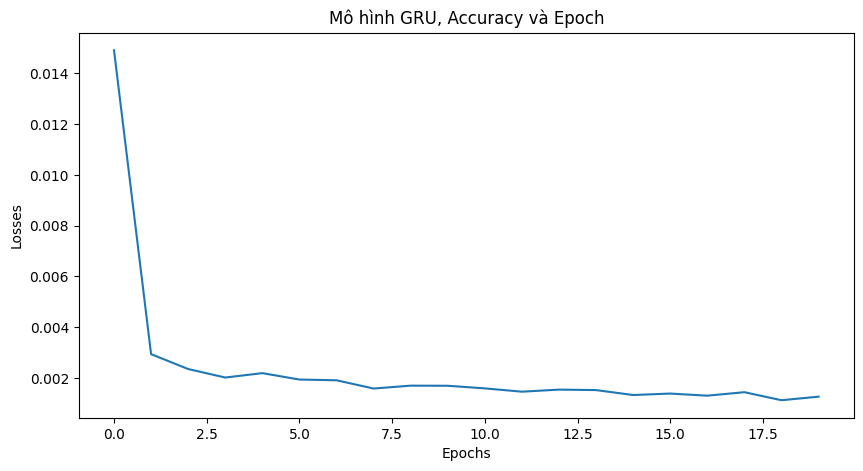

In [104]:
plt.figure(figsize =(10,5))
plt.plot(history3.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Mô hình GRU, Accuracy và Epoch")
plt.show()

In [105]:
# Chuẩn bị dữ liệu train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i-50:i, 0])
    y_train.append(sc_train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape dữ liệu train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Dự đoán giá trên tập train
predicted_prices_train = model.predict(x_train)
predicted_prices_train = sc.inverse_transform(predicted_prices_train)

# Chuyển ngược chuẩn hóa cho giá thực tế trên tập train
y_train_actual = sc.inverse_transform(y_train.reshape(-1, 1))

62/62 [==============================] - 1s 19ms/step


In [106]:
train_data = df1[50:2004]
train_data['Dự đoán'] = predicted_prices_train #thêm dữ liệu
train_data

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\1496276038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Dự đoán'] = predicted_prices_train #thêm dữ liệu


,Đóng cửa,Dự đoán
Ngày,,
2013-09-19,95139.0,94503.093750
2013-09-20,95833.0,94711.296875
2013-09-23,95139.0,95281.867188
2013-09-24,95833.0,95118.265625
2013-09-25,97222.0,95405.656250
...,...,...
2021-07-14,78054.9,78422.460938
2021-07-15,78238.5,78034.640625
2021-07-16,78881.3,78067.734375


In [107]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1954:] #giá thực
y_test_predict = model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

# Kiểm tra và cắt bớt mẫu
min_length = min(len(y_test), len(y_test_predict))
y_test = y_test[:min_length]
y_test_predict = y_test_predict[:min_length]

 1/18 [>.............................] - ETA: 1s

18/18 [==============================] - 0s 19ms/step


In [108]:
test_data = df1[1954:]
test_data['Dự đoán'] = y_test_predict
test_data

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31888\3305084021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Dự đoán'] = y_test_predict


,Đóng cửa,Dự đoán
Ngày,,
2021-05-12,84299.3,83658.945312
2021-05-13,83105.5,84009.937500
2021-05-14,82187.2,83510.289062
2021-05-17,80075.1,82682.515625
2021-05-18,79891.5,81155.312500
...,...,...
2023-07-17,72300.0,73274.539062
2023-07-18,72400.0,72859.250000
2023-07-19,72600.0,72599.046875


## Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 [==============================] - 0s 69ms/step


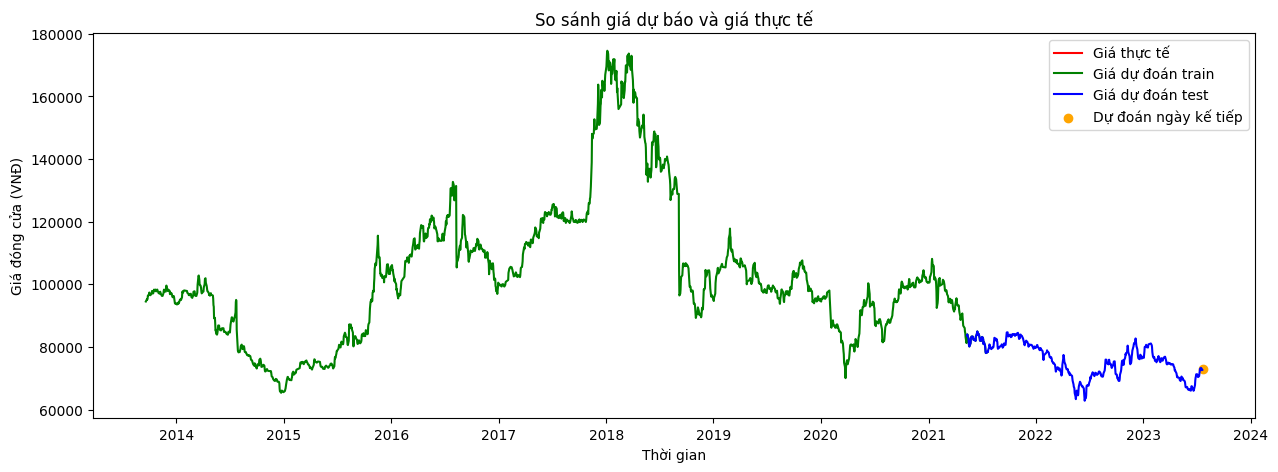

In [109]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp

plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data.index, train_data['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data.index, test_data['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

In [110]:
print('Giá dự đoán ngày ',next_date,' là: ',y_next_predict[0][0])

Giá dự đoán ngày  2023-07-22 00:00:00  là:  73083.66


In [111]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Đóng cửa'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
comparison_df

,Ngày,Giá dự đoán,Giá ngày trước
0,2023-07-22,73083.65625,73500.0
